## Table of Contents
[Bound Tightening](#BoundTightening)    
  - [Prototype for bound tightening procedures](#Prototypeforboundtighteningprocedures)
  - [RR](#RR)
  - [ITER-RR](#ITER-RR) 
  - [LR](#LR)
  
[MILP Model](#MILPModel)  
[Full Model](#Fullmodel)  
[Full Model Hyperbolic](#FullModelHyperbolic)  
[Neural Net Example](#NeuralNet)   
[Neural Net Oil Case](#NeuralNetOilCase)  
[Previous Implementations](#PreviousImplementations) 


In [1]:
from gurobipy import *
import pickle
import numpy as np
from copy import deepcopy

from neural_net_1 import neural_init

## Bound Tightening <a name="BoundTightening"></a>

In [2]:
def total_neurons(weights):
    """
    Input
    weights : Weights of the neural network
    
    Output
    t : total number of neurons in the neural network  
    """
    t = 0
    for layer in weights:
        t += len(layer[0][0])
    return t

# função desatualizada
def inicialize_bounds(weights):
    """
    Input
    weights : Weights of the neural network
    
    Output
    bounds : a zeros numpy array shapped as (total_neurons + len(input_dim), input_dim)
    """
    t = total_neurons(weights) + len(weights[0])
    bounds = np.zeros((t,2))
    return bounds

# função desatualizada
def bound_model(model, x, s, k, j, maximize):
    """
    Input
    model : model to optimize
    x, s  : variables of the model
    k, j  : layer and neuron, respectively
    maximize : objetive of the model (True == maximize False == minimize)
    
    Output
    new_bound : bound generated after the bound tightening procedure
    """
    if maximize:
        model.setObjective(x[k,j] - s[k,j], GRB.MAXIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    else:
        model.setObjective(x[k,j] - s[k,j], GRB.MINIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    return new_bound


def init_bounds(weights, init):
    """
    weights : weights of the neural network
    init : initial value of the bounds (lb = -init, ub = init)
    """   
    # first outer list : layers
    # second outer list : neurons
    # third outer list : lower and upper bound, respectively
    bounds = [[[-init,init] for j in range(len(weights[k][0]))] for k in range(len(weights))]
    bounds.append([[-init,init]])
    return bounds


def show_bounds(bounds):
    for i, layer in enumerate(bounds):
        if i == 0:
            print("Input Layer")
        elif i == len(bounds) - 1:
            print("Output Layer")
        else:
            print("Layer : {}".format(i+1))
        for neuron in layer:
            print("Lower Bound : {} \t Upper Bound : {}".format(neuron[0],neuron[1]))
            
def bound_objective(model, x, s, k, j, maximize):
    """
    Input
    model : model to optimize
    x, s  : variables of the model
    k, j  : layer and neuron, respectively
    maximize : objetive of the model (True == maximize False == minimize)
    
    Output
    new_bound : bound generated after the bound tightening procedure
    """
    if maximize:
        model.setObjective(x[k][j] - s[k,j], GRB.MAXIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    else:
        model.setObjective(x[k][j] - s[k,j], GRB.MINIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    return new_bound


def neurons_at(W, layer):
    # Return the number of neurons of each layer
    return len(W[layer][0][0])


def empty_model(weights, parameters, bounds):
    
    # Create the model
    m = Model('RR')
    m.Params.LogToConsole = 0 # turn off logs
       
    # Local Variables
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
      
    # Model Variables
    x = [[m.addVar(lb=neuron[0], ub=neuron[1]) for neuron in layer] for layer in bounds[:K]] # decision variables
    s = m.addVars(K, nK, lb=0, ub=10) # negative dump
    z = m.addVars(K, nK, lb=0, ub=1) # binary activation variable
    y = m.addVar(lb=bounds[K][0][0],ub=bounds[K][0][1]) # output variable
   
    
    #"""
    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x[0][0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x[0][0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x[0][1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x[0][1] <= (1 - mean_x[1])/std_x[1] )
    #"""
    
    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][neuron]
                Negative part : s[layer][variable]               
                """ 
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x[k][j] - s[k,j] )
                
                
                # Classic ReLu Formulation
                m.addConstr( x[k][j] <= bounds[k][j][1] * z[k,j] )
                m.addConstr( s[k,j] <= -bounds[k][j][0] * (1 - z[k,j]) )
                m.addConstr( x[k][j] >= 0)
                
                
                if bounds[k][j][0] > 0:
                    z[k,j].setAttr(GRB.Attr.LB, 1)  # Neuron activated
                if bounds[k][j][1] < 0:
                    z[k,j].setAttr(GRB.Attr.UB, 0)  # Neuron deactivated
                               
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
            
                  
    m.update()
    
    return m, x, s, z, y


## Prototypes for bound tightening procedures <a name="Prototypeforboundtighteningprocedures"></a>


### Prototype 0

In [3]:
def prototype_0(parameters, weights, bounds):
    """
    Prototype 0 : Where we create the constraints right before calculating the bounds
    Each bound is calculated based on the constraints of the layers 0 to k
    """
    
    # Create the model
    m = Model('bound_tightening')
    m.Params.LogToConsole = 0 # turn off logs
    
    # Local Variables
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
    
    # Model Variables
    x = [[m.addVar(lb=neuron[0], ub=neuron[1]) for neuron in layer] for layer in bounds[:K]] # decision variables
    s = m.addVars(K, nK, lb=0, ub=10) # negative dump
    z = m.addVars(K, nK, lb=0, ub=1) # binary activation variable
    y = m.addVar(lb=-5,ub=5) # output variable
       
    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x[0][0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x[0][0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x[0][1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x[0][1] <= (1 - mean_x[1])/std_x[1] )
    
    for i in range(len(W[0])): # iterates over the neural net inputs
        # Bounds of input
        m.setObjective(x[0][i], GRB.MAXIMIZE)
        m.optimize()
        ub = m.ObjVal
        m.setObjective(x[0][i], GRB.MINIMIZE)
        m.optimize()
        lb = m.ObjVal
        bounds[0][i][0], bounds[0][i][1] = lb, ub
    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]
                """ 
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x[k][j] - s[k,j] )
                
                bounds[k][j][1] = bound_objective(m, x, s, k, j, True) # upper bound 
                bounds[k][j][0] = bound_objective(m, x, s, k, j, False) # lower bound
                
                # Classic ReLu Formulation
                m.addConstr( x[k][j] <= bounds[k][j][1] * z[k,j] )
                m.addConstr( s[k,j] <= -bounds[k][j][0] * (1 - z[k,j]) )
                m.addConstr( x[k][j] >= 0)
                               
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
                
                # Bounds of output
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[k][j][0], bounds[k][j][1] = lb, ub
                
    return bounds

In [4]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
initial_bounds = init_bounds(W, 5) # initialize the bounds
bounds = prototype_0(parameters, W, initial_bounds)
show_bounds(bounds)


--------------------------------------------
--------------------------------------------

Using license file C:\Users\torbe\gurobi.lic
Academic license - for non-commercial use only
Input Layer
Lower Bound : -1.7277260797025042 	 Upper Bound : 1.7277260797025047
Lower Bound : -1.7277260797023208 	 Upper Bound : 1.727726079702321
Layer : 2
Lower Bound : -0.27340875284809796 	 Upper Bound : 0.6420543910755608
Lower Bound : -0.7328680719595796 	 Upper Bound : 0.9671934808951266
Lower Bound : -0.488341184167866 	 Upper Bound : 1.1737879233646435
Lower Bound : -1.1525504335676777 	 Upper Bound : 0.23313740342012518
Lower Bound : -0.2540293587398855 	 Upper Bound : 1.1509430063915578
Lower Bound : -0.20633246035525063 	 Upper Bound : 1.0316915068144488
Lower Bound : -0.7538024692852211 	 Upper Bound : 0.8016267440337848
Lower Bound : -0.8386853599404868 	 Upper Bound : 0.5066104197358665
Lower Bound : -0.11309143250684223 	 Upper Bound : 1.0571106905291505
Lower Bound : -0.715812832095168 

### Prototype 1

In [5]:
def prototype_1(parameters, weights):
    """
    Prototype 1 : Where we create all the constraints and variables before we calculate the bounds
    Each bound is calculated based on the constraints of the layers 0 to K+1
    """
    
    # Create the model
    bounds = init_bounds(weights, 5) # initialize the bounds
    m, x, s, z, y = empty_model(weights, parameters, bounds)
    
    K = len(weights) # Number of layers in the neural network
    
    
        
    for i in range(len(W[0])): # iterates over the neural net inputs
        # Bounds of input
        m.setObjective(x[0][i], GRB.MAXIMIZE)
        m.optimize()
        ub = m.ObjVal
        m.setObjective(x[0][i], GRB.MINIMIZE)
        m.optimize()
        lb = m.ObjVal
        bounds[0][i][0], bounds[0][i][1] = lb, ub
    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]              
                """ 
                
                
                bounds[k][j][1] = bound_objective(m, x, s, k, j, True) # upper bound 
                bounds[k][j][0] = bound_objective(m, x, s, k, j, False) # lower bound
                               
            else: # OUTPUT LAYER
                
                # Bounds of output
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[k][j][0], bounds[k][j][1] = lb, ub
                
    return bounds

In [6]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
bounds = prototype_1(parameters, W)
show_bounds(bounds)

Input Layer
Lower Bound : -1.7277260797025042 	 Upper Bound : 1.7277260797025047
Lower Bound : -1.7277260797023208 	 Upper Bound : 1.7277260797023208
Layer : 2
Lower Bound : -0.27340875284809796 	 Upper Bound : 0.6420543910755612
Lower Bound : -0.7328680719595797 	 Upper Bound : 0.9671934808951266
Lower Bound : -0.488341184167866 	 Upper Bound : 1.1737879233646433
Lower Bound : -1.1525504335676777 	 Upper Bound : 0.23313740342012518
Lower Bound : -0.2540293587398854 	 Upper Bound : 1.1509430063915578
Lower Bound : -0.20633246035525063 	 Upper Bound : 1.0316915068144488
Lower Bound : -0.7538024692852211 	 Upper Bound : 0.8016267440337848
Lower Bound : -0.8386853599404867 	 Upper Bound : 0.5066104197358663
Lower Bound : -0.11309143250684223 	 Upper Bound : 1.0571106905291505
Lower Bound : -0.715812832095168 	 Upper Bound : 1.0456498265047292
Layer : 3
Lower Bound : -5.0 	 Upper Bound : 0.6668549724835865
Lower Bound : -2.929534043051771 	 Upper Bound : 5.0
Lower Bound : -3.40503348338806

### RR <a name="RR"></a>

In [54]:
def empty_model_RR(weights, parameters, bounds):
    
    # Create the model
    m = Model('RR')
    m.Params.LogToConsole = 0 # turn off logs
       
    # Local Variables
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
      
    # Model Variables
    x = [[m.addVar(lb=neuron[0], ub=neuron[1]) for neuron in layer] for layer in bounds[:K]] # decision variables   
    s = m.addVars(K, nK, lb=0, ub=10) # negative dump
    z = m.addVars(K, nK, lb=0, ub=1) # binary activation variable
    y = m.addVar(lb=bounds[K][0][0],ub=bounds[K][0][1]) # output variable
    
 
    m.update()
    for k,layer in enumerate(x):
        for j,neuron in enumerate(layer):
            if neuron.ub < 0:         
                neuron.ub = 0
    m.update()
    
    #"""
    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x[0][0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x[0][0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x[0][1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x[0][1] <= (1 - mean_x[1])/std_x[1] )
    #"""

    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][neuron]
                Negative part : s[layer][variable]               
                """ 
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x[k][j] - s[k,j] )
                
                # Classic ReLu Formulation
                m.addConstr( x[k][j] <= bounds[k][j][1] * z[k,j], 'Uk{}j{}'.format(k,j))
                m.addConstr( s[k,j] <= -bounds[k][j][0] * (1 - z[k,j]), 'Lk{}j{}'.format(k,j))
                m.addConstr( x[k][j] >= 0)
                
                """
                if bounds[k][j][1] < 0:
                    z[k,j].lb , z[k,j].ub = 0, 0
                    m.update()
                    # print("ub < 0, z = ",z[k,j].obj)
                if bounds[k][j][0] > 0:
                    z[k,j].lb , z[k,j].ub = 1, 1
                    m.update()
                    # print("lb > 0, z = ",z[k,j].obj)
                #"""
                                             
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
            
                  
    m.update()
    
    return m, x, s, z, y

In [55]:
def RR(parameters, weights, init_bounds):
    """
    parameters : dictionary with some parameters of the neural net input 
    weights : numpy array with the neural net weights  
    bounds : numpy array with the initial bounds
    """
    
    K = len(weights) # Number of layers in the neural network
    bounds = deepcopy(init_bounds)
    m, x, s, z, y = empty_model_RR(weights, parameters, bounds)
     
    #"""
    for i in range(len(W[0])): # iterates over the neural net inputs
        # Bounds of input
        m.setObjective(x[0][i], GRB.MAXIMIZE)
        m.optimize()
        ub = m.ObjVal
        m.setObjective(x[0][i], GRB.MINIMIZE)
        m.optimize()
        lb = m.ObjVal
        bounds[0][i][0], bounds[0][i][1] = lb, ub
    #"""
    """
    for i in range(len(weights[0])): # iterates over the neural net inputs
        # Bounds of input
        bounds[0][i][0], bounds[0][i][1] = bounds[K][0][0], bounds[K][0][1]
    #"""
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            # print(k,j)
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]               
                """                 
                # print('k',k,'j',j)
                bounds[k][j][1] = bound_objective(m, x, s, k, j, True)  # upper bound 
                bounds[k][j][0] = bound_objective(m, x, s, k, j, False) # lower bound
                
                # print('k ',k,'j ',j ,'LB ',bounds[k][j][0] ,'UB ', bounds[k][j][1], 'ABS ', abs(bounds[k][j][1] - bounds[k][j][0]))
                
                # First Method (ITER-RR doesn't work, but the bounds are ok)
                m.remove(m.getConstrByName('Uk{}j{}'.format(k,j)))
                m.remove(m.getConstrByName('Lk{}j{}'.format(k,j)))
                m.update()
                m.addConstr( x[k][j] <= bounds[k][j][1] * z[k,j], 'Uk{}j{}'.format(k,j))
                m.addConstr( s[k,j] <= -bounds[k][j][0] * (1 - z[k,j]), 'Lk{}j{}'.format(k,j))
                
                
                assert bounds[k][j][1] >= bounds[k][j][0]

                
                
                # Second Method (Not Working)
                # Change the constraint by updating variable z coeffcient (bounds)
                # m.chgCoeff(m.getConstrByName('Uk{}j{}'.format(k,j)), z[k,j], bounds[k][j][1]) 
                # m.chgCoeff(m.getConstrByName('Lk{}j{}'.format(k,j)), z[k,j], -bounds[k][j][0])
                
                m.update()

                
                               
            else: # OUTPUT LAYER           
                # Bounds of output     
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[k][j][0], bounds[k][j][1] = lb, ub
       
            
            assert bounds[k][j][1] >= bounds[k][j][0]
                

    
    return bounds

In [56]:
initial_b = init_bounds(W,5)
b1 = RR(parameters, W, initial_b)
show_bounds(b1)

Input Layer
Lower Bound : -1.7277260797025042 	 Upper Bound : 1.7277260797025047
Lower Bound : -1.7277260797023208 	 Upper Bound : 1.7277260797023208
Layer : 2
Lower Bound : -0.27340875284809796 	 Upper Bound : 0.6420543910755612
Lower Bound : -0.7328680719595795 	 Upper Bound : 0.9671934808951264
Lower Bound : -0.488341184167866 	 Upper Bound : 1.173787923364643
Lower Bound : -1.1525504335676777 	 Upper Bound : 0.2331374034201248
Lower Bound : -0.2540293587398854 	 Upper Bound : 1.1509430063915578
Lower Bound : -0.20633246035525055 	 Upper Bound : 1.0316915068144479
Lower Bound : -0.7538024692852211 	 Upper Bound : 0.8016267440337845
Lower Bound : -0.8386853599404868 	 Upper Bound : 0.5066104197358667
Lower Bound : -0.11309143250684195 	 Upper Bound : 1.057110690529151
Lower Bound : -0.715812832095168 	 Upper Bound : 1.0456498265047292
Layer : 3
Lower Bound : -1.1874251428740699 	 Upper Bound : -0.22943133470023191
Lower Bound : -0.24681178908949924 	 Upper Bound : 0.8295005909964845


In [57]:
b1 = init_bounds(W,5)
for i in range(15):
    b1 = RR(parameters, W, b1)

show_bounds(b1)
    

Input Layer
Lower Bound : -1.7277260797025042 	 Upper Bound : 1.7277260797025047
Lower Bound : -1.7277260797023208 	 Upper Bound : 1.7277260797023208
Layer : 2
Lower Bound : -0.2734087528480979 	 Upper Bound : 0.6420543910755612
Lower Bound : -0.7328680719595795 	 Upper Bound : 0.9671934808951264
Lower Bound : -0.488341184167866 	 Upper Bound : 1.173787923364643
Lower Bound : -1.1525504335676768 	 Upper Bound : 0.2331374034201248
Lower Bound : -0.25402935873988575 	 Upper Bound : 1.1509430063915578
Lower Bound : -0.20633246035525066 	 Upper Bound : 1.0316915068144479
Lower Bound : -0.753802469285221 	 Upper Bound : 0.8016267440337845
Lower Bound : -0.8386853599404865 	 Upper Bound : 0.5066104197358664
Lower Bound : -0.11309143250684232 	 Upper Bound : 1.0571106905291505
Lower Bound : -0.715812832095168 	 Upper Bound : 1.0456498265047292
Layer : 3
Lower Bound : -1.1874251428740699 	 Upper Bound : -0.22943133470023205
Lower Bound : -0.24681178908949924 	 Upper Bound : 0.8295005909964845


### RR_1

In [34]:
def empty_model_RR_1(weights, parameters, bounds):
    """The same function as empty_model() but with a commented part
       Some problems are occuring with the ITER-RR, with this the model at least can be executed when init = 10
       """
    
    # Create the model
    m = Model('RR')
    m.Params.LogToConsole = 0 # turn off logs
       
    # Local Variables
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
    
    
    # Model Variables
    x = [[m.addVar(lb=neuron[0], ub=neuron[1]) for neuron in layer] for layer in bounds[:K]] # decision variables
    #"""
    m.update()
    for layer in x:
        for neuron in layer:
            if neuron.ub < 0:
                neuron.ub = 0

    m.update()
    #"""
    
    s = m.addVars(K, nK, lb=0, ub=10) # negative dump
    z = m.addVars(K, nK, lb=0, ub=1) # binary activation variable
    y = m.addVar(lb=bounds[K][0][0],ub=bounds[K][0][1]) # output variable
    
    
    """
    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x[0][0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x[0][0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x[0][1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x[0][1] <= (1 - mean_x[1])/std_x[1] )
    #"""

    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][neuron]
                Negative part : s[layer][variable]               
                """ 
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x[k][j] - s[k,j] )
                
                # Classic ReLu Formulation
                m.addConstr( x[k][j] <= bounds[k][j][1] * z[k,j], 'Uk{}j{}'.format(k,j))
                m.addConstr( s[k,j] <= -bounds[k][j][0] * (1 - z[k,j]), 'Lk{}j{}'.format(k,j))
                m.addConstr( x[k][j] >= 0)
                           
                assert bounds[k][j][1] >= bounds[k][j][0]
                if bounds[k][j][1] < 0:
                    z[k,j].lb , z[k,j].ub = 0, 0
                    m.update()
                    # print("ub < 0, z = ",z[k,j].obj)
                if bounds[k][j][0] > 0:
                    z[k,j].lb , z[k,j].ub = 1, 1
                    m.update()
                    # print("lb > 0, z = ",z[k,j].obj)
                    
                
                
                
                               
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
            
                  
    m.update()
    
    return m, x, s, z, y

In [35]:
def RR_1(parameters, weights, init_bounds):
    """
    parameters : dictionary with some parameters of the neural net input 
    weights : numpy array with the neural net weights  
    bounds : numpy array with the initial bounds
    """
    
    bounds = deepcopy(init_bounds)
    K = len(weights) # Number of layers in the neural network
    """
    m, x, s, z, y = empty_model_RR_1(weights, parameters, bounds)
    for i in range(len(weights[0])): # iterates over the neural net inputs
        # Bounds of input
        bounds[0][i][0], bounds[0][i][1] = bounds[K][0][0], bounds[K][0][1]
    #"""
    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        m, x, s, z, y = empty_model_RR_1(weights, parameters, bounds)
        for j in range(neuronios): # Iterate over the neurons of the layer
            
            
            if k > 0 and k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]               
                """                 
                
                bounds[k][j][1] = bound_objective(m, x, s, k, j, True)  # upper bound 
                bounds[k][j][0] = bound_objective(m, x, s, k, j, False) # lower bound
                #print(bounds[k][j], 'k ',k,'j ',j)
                              
            else: # OUTPUT LAYER           
                # Bounds of output
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[k][j][0], bounds[k][j][1] = lb, ub
       
            
            
                

    
    return bounds

In [36]:
initial_b = init_bounds(W,5)    
b1 = RR_1(parameters, W, initial_b)
show_bounds(b1) 

Input Layer
Lower Bound : -5 	 Upper Bound : 5
Lower Bound : -5 	 Upper Bound : 5
Layer : 2
Lower Bound : -1.1403419449925423 	 Upper Bound : 1.508987583220005
Lower Bound : -2.342807039618492 	 Upper Bound : 2.577132448554039
Lower Bound : -2.0623585572466254 	 Upper Bound : 2.7478052964434028
Lower Bound : -2.4647810654714704 	 Upper Bound : 1.5453680353239179
Lower Bound : -1.5845222196076065 	 Upper Bound : 2.481435867259279
Lower Bound : -1.3787270858883853 	 Upper Bound : 2.2040861323475838
Lower Bound : -2.2267762552946806 	 Upper Bound : 2.2746005300432444
Lower Bound : -2.1126651726663113 	 Upper Bound : 1.780590232461691
Lower Bound : -1.2212595425080508 	 Upper Bound : 2.165278800530359
Lower Bound : -2.3838979490101337 	 Upper Bound : 2.713734943419695
Layer : 3
Lower Bound : -2.9563850910208354 	 Upper Bound : -0.03503497925396859
Lower Bound : -1.2174696747461002 	 Upper Bound : 2.607642947022047
Lower Bound : -1.3717206783428464 	 Upper Bound : 1.15699707097663
Lower Bou

In [35]:
for i in range(10):
    b1 = deepcopy(RR_1(parameters, W, b1))
show_bounds(b1)    

Input Layer
Lower Bound : -5 	 Upper Bound : 5
Lower Bound : -5 	 Upper Bound : 5
Layer : 2
Lower Bound : -0.27340875284809796 	 Upper Bound : 0.6420543910755608
Lower Bound : -0.7328680719595796 	 Upper Bound : 0.9671934808951267
Lower Bound : -0.488341184167866 	 Upper Bound : 1.1737879233646433
Lower Bound : -1.1525504335676777 	 Upper Bound : 0.23313740342012518
Lower Bound : -0.2540293587398855 	 Upper Bound : 1.1509430063915578
Lower Bound : -0.20633246035525063 	 Upper Bound : 1.0316915068144488
Lower Bound : -0.753802469285221 	 Upper Bound : 0.8016267440337848
Lower Bound : -0.8386853599404868 	 Upper Bound : 0.5066104197358665
Lower Bound : -0.11309143250684223 	 Upper Bound : 1.0571106905291505
Lower Bound : -0.715812832095168 	 Upper Bound : 1.0456498265047292
Layer : 3
Lower Bound : -1.18742514287407 	 Upper Bound : -0.22943133470023205
Lower Bound : -0.24681178908949963 	 Upper Bound : 0.8295005909964843
Lower Bound : -0.26065242465140187 	 Upper Bound : 0.558442096348667

### ITER-RR <a name="ITER-RR"></a>

In [32]:
def MAD(bounds):
    soma = 0
    i = 0
    for layer in bounds:
        for neuron in layer:
            i += 1
            soma += abs(neuron[1] - neuron[0])
    return soma / i
            
    
def ITER_RR(parameters, weights, init_bounds, max_iter, ref):
    
    i = 0 # iterator
    ratio = 0 # [0-1] range
    m_0 = MAD(init_bounds) # MAD of the initial bounds
    bounds = deepcopy(init_bounds) 
    
    while ratio <= ref  and  i <= max_iter:
        bounds = RR_1(parameters, weights, bounds)
        m = MAD(bounds)
        ratio = m / m_0
        m_0 = m
        print(ratio)
        
        i += 1
    
    return bounds

In [37]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
initial_b = init_bounds(W,5)
iter_bounds = ITER_RR(parameters, W, initial_b, 200, 0.999)
show_bounds(iter_bounds)

0.4255904360997351
0.9900944918894189
0.99922983270076
Input Layer
Lower Bound : -5 	 Upper Bound : 5
Lower Bound : -5 	 Upper Bound : 5
Layer : 2
Lower Bound : -1.1052279687114324 	 Upper Bound : 1.508987583220005
Lower Bound : -2.1322563431356754 	 Upper Bound : 2.5771324485540394
Lower Bound : -2.0528247002910107 	 Upper Bound : 2.7478052964434028
Lower Bound : -2.4647810654714704 	 Upper Bound : 1.5323305298034935
Lower Bound : -1.5845222196076065 	 Upper Bound : 2.480647783621844
Lower Bound : -1.3682238557478035 	 Upper Bound : 2.2040861323475838
Lower Bound : -2.2267762552946806 	 Upper Bound : 2.159159927774918
Lower Bound : -2.0062097878076934 	 Upper Bound : 1.780590232461691
Lower Bound : -1.2212595425080508 	 Upper Bound : 2.1634402839422857
Lower Bound : -2.2734694795126296 	 Upper Bound : 2.713734943419695
Layer : 3
Lower Bound : -2.9563850910208354 	 Upper Bound : -0.038557296121993656
Lower Bound : -1.215587999546331 	 Upper Bound : 2.55612276453088
Lower Bound : -1.358

### LR <a name="LR"></a>

In [15]:
def teste2(model,x,s,maximize,new,neuronios):
    """
    Input
    model : model to optimize
    x, s  : variables of the model
    k, j  : layer and neuron, respectively
    maximize : objetive of the model (True == maximize False == minimize)
    
    Output
    new_bound : bound generated after the bound tightening procedure
    """
    if maximize:
        model.setObjective(x[new+neuronios] - s[new+neuronios], GRB.MAXIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    else:
        model.setObjective(x[new+neuronios] - s[new+neuronios], GRB.MINIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    return new_bound



def layer_relax(bounds, weights, k, j, previous_x, parameters):
    m = Model('LRR_neuron')
    m.Params.LogToConsole = 0 # turn off logs
    
    if k == 1:       
        # Input parameters
        mean_x = parameters['mean_x']
        std_x = parameters['std_x']
        mean_y = parameters['mean_y']
        std_y = parameters['std_y']
        
        # Model Variables
        previous_x = [m.addVar(lb=-1, ub=5) for i in range(len(weights[0][0]))] # decision variables
        
        # Constraints of the upper and lower bounds of normalized x0
        m.addConstr( previous_x[0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
        m.addConstr( previous_x[0] <= (1 - mean_x[0])/std_x[0] )   

        # Constraints of upper and lower bounds of normalized x1
        m.addConstr( previous_x[1] >= (-1 - mean_x[1])/std_x[1] )
        m.addConstr( previous_x[1] <= (1 - mean_x[1])/std_x[1] )

        
    x_0 = [m.addVar(lb=-1,ub=5) for i in range(len(previous_x))]
    s = m.addVar(lb=0,ub=10)
    z = m.addVar(lb=0,ub=1)
    x = m.addVar(lb=-1,ub=5)
    
    for var1,var2 in zip(x_0,previous_x):
        print(var1,var2)
        m.addConstr(var1.obj == var2.obj)

    # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k )
    m.addConstr( sum( weights[k-1][0][i][j] * x_0[i] for i in range(len(weights[k-1][0])))
        + weights[k-1][1][j] == x - s )
    
    m.setObjective(x - s, GRB.MAXIMIZE)
    m.optimize()
    ub = m.ObjVal
    
    m.setObjective(x - s, GRB.MINIMIZE)
    m.optimize()
    lb = m.ObjVal
    
    
    # Classic ReLu Formulation
    m.addConstr( x <= bounds[aux,0] * z )
    m.addConstr( s <= -bounds[aux,1] * (1 - z ))
    m.addConstr( x >= 0)
            
    return ub, lb, x
        
    


In [16]:
def LRR(parameters, weights):
    
    # Create the model
    m = Model('bound_tightening')
    m.Params.LogToConsole = 0 # turn off logs
    
    # Local Variables
    bounds = inicialize_bounds(weights)
    aux = 2 # index of the bounds array
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
           
    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Model Variables
    x_0 = [m.addVar(lb=-1, ub=5) for i in range(len(weights[0][0]))] # decision variables
    y = m.addVar(lb=-5,ub=5) # output variable
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x_0[0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x_0[0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x_0[1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x_0[1] <= (1 - mean_x[1])/std_x[1] )
    
    for i in range(len(W[0])): # iterates over the neural net inputs
        # Bounds of input
        m.setObjective(x_0[i], GRB.MAXIMIZE)
        m.optimize()
        ub = m.ObjVal
        m.setObjective(x_0[i], GRB.MINIMIZE)
        m.optimize()
        lb = m.ObjVal
        bounds[i,1], bounds[i,0] = lb, ub
    
    previous = [x_0]
    current = [[]]
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]
                """ 

                # print('layer ',k, ' neuron ',j)
                x = m.addVar(lb=-1,ub=5)
                s = m.addVar(lb=0,ub=10) 
                z = m.addVar(lb=0,ub=1)          

                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k )
                m.addConstr( sum( weights[k-1][0][i][j] * previous[0][i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x - s )
          
                bounds[aux,0] = teste3(m,x,s,True)
                bounds[aux,1] = teste3(m,x,s,False)
                assert bounds[aux,0] >= bounds[aux,1]                   
                
                # Classic ReLu Formulation
                m.addConstr( x <= bounds[aux,0] * z )
                m.addConstr( s <= -bounds[aux,1] * (1 - z ))
                m.addConstr( x >= 0)
                current[0].append(x)            
                
                # m.remove(s)
                # m.remove(z)
                # m.update()
                
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                m.addConstr( sum( weights[k-1][0][i][j] * previous[0][i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
                
                # Bounds of output
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[aux,1], bounds[aux,0] = lb, ub        
            
            aux += 1
        # for var in previous[0]:
        #    m.remove(var)
        m.update()
         
        previous[0] = current[0]
        current[0] = []
        
    
    return bounds

In [61]:
def LRR(parameters, weights):
    
    # Create the model
    m = Model('bound_tightening')
    m.Params.LogToConsole = 0 # turn off logs
    
    # Local Variables
    bounds = inicialize_bounds(weights)
    aux = 2 # index of the bounds array
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
           
    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Model Variables
    x_0 = [m.addVar(lb=-1, ub=5) for i in range(len(weights[0][0]))] # decision variables
    y = m.addVar(lb=-5,ub=5) # output variable
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x_0[0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x_0[0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x_0[1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x_0[1] <= (1 - mean_x[1])/std_x[1] )
    
    for i in range(len(W[0])): # iterates over the neural net inputs
        # Bounds of input
        m.setObjective(x_0[i], GRB.MAXIMIZE)
        m.optimize()
        ub = m.ObjVal
        m.setObjective(x_0[i], GRB.MINIMIZE)
        m.optimize()
        lb = m.ObjVal
        bounds[i,1], bounds[i,0] = lb, ub
    
    previous = [x_0]
    current = [[]]
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]
                """ 

                # print('layer ',k, ' neuron ',j)
                x = m.addVar(lb=-1,ub=5)
                s = m.addVar(lb=0,ub=10) 
                z = m.addVar(lb=0,ub=1)          

                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k )
                m.addConstr( sum( weights[k-1][0][i][j] * previous[0][i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x - s )
          
                bounds[aux,0] = teste3(m,x,s,True)
                bounds[aux,1] = teste3(m,x,s,False)
                assert bounds[aux,0] >= bounds[aux,1]                   
                
                # Classic ReLu Formulation
                m.addConstr( x <= bounds[aux,0] * z )
                m.addConstr( s <= -bounds[aux,1] * (1 - z ))
                m.addConstr( x >= 0)
                current[0].append(x)            
                
                # m.remove(s)
                # m.remove(z)
                # m.update()
                
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                m.addConstr( sum( weights[k-1][0][i][j] * previous[0][i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
                
                # Bounds of output
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[aux,1], bounds[aux,0] = lb, ub        
            
            aux += 1
        # for var in previous[0]:
        #    m.remove(var)
        m.update()
         
        previous[0] = current[0]
        current[0] = []
        
    
    return bounds

In [62]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
bounds_0 = LRR(parameters, W)
bounds_0

NameError: name 'teste3' is not defined

In [ ]:
bounds


### MILP Model <a name="MILPModel"></a>

In [12]:
def model(parameters, weights):

    m = Model('milp')
    m.Params.LogToConsole = 0 # turn off logs
    
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer

    
    x = m.addVars(K, nK,lb=-1,ub=5) # decision variables
    s = m.addVars(K, nK, lb=0, ub=10) # negative dump
    z = m.addVars(K, nK, vtype=GRB.BINARY) # binary activation variable
    y = m.addVar(lb=-5,ub=5) # output variable
    
    # Initial bounds
    U = 5
    L = -5
    
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']

    # Constraints of upper and lower bounds of normalized x0
    # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x[0,0] >= (-1 - mean_x[0])/std_x[0] ) 
    m.addConstr( x[0,0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x[0,1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x[0,1] <= (1 - mean_x[1])/std_x[1] )
    
    #m.addConstr( x[0,1] >= (-1 - avg[1])/std[1] )
    #m.addConstr( x[0,1] <= (1 - avg[1])/std[1] )
    #m.addConstr( x[0,0] == (9.03 - avg[0])/std[0] )
    #m.addConstr( x[0,1] == (200000 - avg[1])/std[1] )

    M = 10000
    t = 0.0

    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = len(weights[k-1][0][0]) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]
                """ 
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1,i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x[k,j] - s[k,j] )

                # Hyperbolic
                # m.addConstr( x[k,j] == 0.5 * (s[k,j] + a[k,j]) )
                # m.addConstr( a[k,j] * a[k,j] == s[k,j] * s[k,j] + t * t )

                # Big-M comum
                #m.addConstr( x[k,j] >= s[k,j] )
                #m.addConstr( x[k,j] >= 0 )
                #m.addConstr( x[k,j] <= 0 + M * (1 - z[k,j]) )
                #m.addConstr( x[k,j] <= s[k,j] + M * (z[k,j]) )
    
                # Classic ReLu Formulation
                m.addConstr( x[k,j] <= U * z[k,j] )
                m.addConstr( s[k,j] <= -L * (1 - z[k,j]) )
                m.addConstr( x[k,j] >= 0)
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1,i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )

    #m.addConstr(y == (896.7 - avg_y) / stdev_y)
    m.setObjective(y, GRB.MAXIMIZE)
    m.update()
    m.setParam("OutputFlag", 1)
    m.setParam("MIPGap", 1e-4)
    m.setParam("NonConvex", 2);
    m.optimize()

    #print(x)
    #print('Cortados')
    #print(s)
    print('Output')
    print(y.x)
    print(y.x * 0.78396923 + 0.84071631)
    print('Input')

    #print(x[0,0].x)
    #print(x[0,1].x)
    print(x[0,0].x * std_x[0] + mean_x[0])
    print(x[0,1].x * std_x[1] + mean_x[1])

    print('binarias')
    print(len(z))

In [13]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
model(parameters, W)

Output
1.489664724989543
2.0085676174082137
Input
0.8109743809687833
-0.07623022841082316
binarias
40


In [ ]:
with open('model.pickle', 'rb') as inputfile:
    W = pickle.load(inputfile)

print(W[0])
print(len(W[0]))
for w in W:
    print('Weights')
    print(w[0])
    print('Bias')
    print(w[1])
    print('________________________________________________________________________________')

### Full model <a name="Fullmodel"></a>

In [119]:
def main_model_with_bounds(parameters, weights, bounds):
    
    # Create the model
    m = Model('full')
    m.Params.LogToConsole = 0 # turn off logs
    
    # Local Variables
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer

    # Model Variables
    x = [[m.addVar(lb=neuron[0], ub=neuron[1]) for neuron in layer] for layer in bounds[:K]] # decision variables
    m.update()
    for layer in x:
        for neuron in layer:
            if neuron.ub < 0:
                neuron.ub = 0
            if neuron.lb > 0:
                neuron.lb = 0
    m.update()
    s = m.addVars(K, nK, lb=0, ub=10) # negative dump
    z = m.addVars(K, nK, vtype=GRB.BINARY) # binary activation variable
    y = m.addVar(lb=bounds[K][0][0],ub=bounds[K][0][1]) # output variable

    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x[0][0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x[0][0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x[0][1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x[0][1] <= (1 - mean_x[1])/std_x[1] )

    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]
                
                """ 
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x[k][j] - s[k,j] )
                
                
                if bounds[k][j][1] < 0:
                    z[k,j].lb , z[k,j].ub = 0, 0
                if bounds[k][j][0] > 0:
                    z[k,j].lb , z[k,j].ub = 1, 1
                    
                assert bounds[k][j][1] >= bounds[k][j][0]
                
                # Classic ReLu Formulation
                m.addConstr( x[k][j] <= bounds[k][j][1] * z[k,j] )
                m.addConstr( s[k,j] <= - bounds[k][j][0] * (1 - z[k,j]) )
                m.addConstr( x[k][j] >= 0)
                               
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
            
    
    m.setObjective(y, GRB.MAXIMIZE)
    m.update()
    m.setParam("OutputFlag", 1)
    m.setParam("MIPGap", 1e-4)
    m.setParam("NonConvex", 2);
    m.optimize()

    print('Output')
    print('Normalized {}    Real {}'.format(y.x, y.x * std_y + mean_y))
  
    print('Input')
    print('Xo Normalized {}    Real {}'.format(x[0][0].x, x[0][0].x * std_x[0] + mean_x[0]))
    print('X1 Normalized {}    Real {}'.format(x[0][1].x, x[0][1].x * std_x[1] + mean_x[1]))


    print('binarias')
    print(len(z))


In [120]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
b_RR = RR(parameters, W, init_bounds(W,10))
b_1 = prototype_1(parameters, W)

print('MAD b_RR : ', MAD(b_RR),'MAD b_1 : ', MAD(b_1)) # b_1 bounds are weaker
try:
    main_model_with_bounds(parameters, W, b_RR)
    print('sucess b_RR')
except:
    print('failure b_RR')
    
try:
    main_model_with_bounds(parameters, W, b_1)
    print('sucess b_1')
except:
    print('failure b_1')
    


MAD b_RR :  1.5652317620208744 MAD b_1 :  5.209242953684459
Output
Normalized 1.489664724989543    Real 2.008567620056989
Input
Xo Normalized 1.401141587970361    Real 0.8109743809687833
X1 Normalized -0.13170495368704388    Real -0.07623022841082316
binarias
40
sucess b_RR
Output
Normalized 1.4896647249895425    Real 2.008567620056989
Input
Xo Normalized 1.401141587970361    Real 0.8109743809687833
X1 Normalized -0.13170495368704388    Real -0.07623022841082316
binarias
40
sucess b_1


### Full Model Hyperbolic <a name="FullModelHyperbolic"></a>

In [118]:
def main_model_with_bounds_flying(parameters, weights, bounds):
    
    # Create the model
    m = Model('main_hiperbolic')
    #m.Params.LogToConsole = 0 # turn off logs
    
    # Local Variables
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
        
    # Model Variables
    x = [[m.addVar(lb=neuron[0], ub=neuron[1]) for neuron in layer] for layer in bounds[:K]] # decision variables
    s = m.addVars(K, nK, lb=-5, ub=5) # negative dump
    z = m.addVars(K, nK, vtype=GRB.BINARY) # binary activation variable
    y = m.addVar(lb=bounds[K][0][0],ub=bounds[K][0][1]) # output variable
    a = m.addVars(K, nK) # auxiliary variable
     
    m.update()
    for k,layer in enumerate(x):
        for j,neuron in enumerate(layer):
            if neuron.ub < 0:         
                neuron.ub = 0
                #s[k,j].lb = - neuron.ub
                z[k,j].lb , z[k,j].ub = 0, 0
            if neuron.lb >= 0:            
                #s[k,j].ub = 0
                z[k,j].lb , z[k,j].ub = 1, 1
            else:
                pass
                #s[k,j].ub = - neuron.lb
                
    m.update()
    
    
    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x[0][0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x[0][0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x[0][1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x[0][1] <= (1 - mean_x[1])/std_x[1] )
    
    t = 0.5
    
    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]
                """ 
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == s[k,j] )
                
                
                
                    
                
                m.addConstr( x[k][j] == 0.5 * (s[k,j] + a[k,j]) ) 
                m.addConstr( a[k,j] * a[k,j] == s[k,j] * s[k,j] + t * t )
                
                # Classic ReLu Formulation
                m.addConstr( x[k][j] <= bounds[k][j][1] * z[k,j] )
                m.addConstr( x[k][j] >= -bounds[k][j][0] * (1 - z[k,j]) )
                #m.addConstr( x[k][j] >= 0)
                               
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
            
            
    
    m.setObjective(y, GRB.MAXIMIZE)
    m.update()
    m.setParam("OutputFlag", 1)
    m.setParam("MIPGap", 1e-4)
    m.setParam("NonConvex", 2);
    m.optimize()

    print('Output')
    print('Normalized {}    Real {}'.format(y.x, y.x * std_y + mean_y))
  
    print('Input')
    print('Xo Normalized {}    Real {}'.format(x[0][0].x, x[0][0].x * std_x[0] + mean_x[0]))
    print('X1 Normalized {}    Real {}'.format(x[0][1].x, x[0][1].x * std_x[1] + mean_x[1]))


    print('binarias')
    print(len(z))


In [116]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
b_RR = RR(parameters, W, init_bounds(W,10))
b_0 = prototype_1(parameters, W)

print('MAD b_RR : ', MAD(b_RR),'MAD b_0 : ', MAD(b_0)) # b_0 bounds are weaker
try:
    main_model_with_bounds_flying(parameters, W, b_RR)
    print('sucess b_RR')
except:
    print('failure b_RR')
    
try:
    main_model_with_bounds_flying(parameters, W, b_0)
    print('sucess b_0')
except:
    print('failure b_0')

MAD b_RR :  1.5652317620208744 MAD b_0 :  5.209242953684459
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Parameter MIPGap unchanged
   Value: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 125 rows, 153 columns and 475 nonzeros
Model fingerprint: 0x97b0d499
Model has 30 quadratic constraints
Variable types: 113 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [7e-04, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-02, 5e+00]
  RHS range        [2e-02, 3e+00]
  QRHS range       [3e-01, 3e-01]
Presolve removed 35 rows and 60 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 16 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasi

In [117]:
main_model_with_bounds_flying(parameters, W, b_RR)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Parameter MIPGap unchanged
   Value: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 125 rows, 153 columns and 475 nonzeros
Model fingerprint: 0x97b0d499
Model has 30 quadratic constraints
Variable types: 113 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [7e-04, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-02, 5e+00]
  RHS range        [2e-02, 3e+00]
  QRHS range       [3e-01, 3e-01]
Presolve removed 35 rows and 60 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 16 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Output


AttributeError: Unable to retrieve attribute 'x'

### Neural Net Example <a name="NeuralNet"></a>
 

In [149]:
import keras
import numpy as np
from keras.layers import Dense
from sklearn import preprocessing
import pickle
import itertools



#  Cria um array de -1 a 1 espaçado 400 vezes iguais
x1 = np.linspace(-1, 1, 400) # var 1
x2 = np.linspace(-1, 1, 400) # var 2

x = np.array(list(itertools.product(x1, x2)))

# Função descrita pela rede neural
y = np.sin(2 * x[:, 0]) + np.cos(x[:, 1])

#  Média e Desvio Padrão da entrada
mean_x = np.mean(x, axis=0)
std_x = np.std(x, axis=0)

#  Média e Desvio Padrão da saída
mean_y = np.mean(y, axis=0)
std_y = np.std(y, axis=0)

parameters = {'x': x, 'y': y,
            'mean_x': mean_x, 'mean_y': mean_y,
            'std_x': std_x, 'std_y': std_y}

x = parameters['x']
y = parameters['y']

mean_x = parameters["mean_x"]
print("mean_x =", mean_x)

std_x = parameters['std_x']
print("std_x =", std_x)

mean_y = parameters['mean_y']
print("mean_y =", mean_y)

std_y = parameters['std_y']
print("std_y =", std_y)

#  Normalização da entrada e da saída
x_norm = (x - mean_x) / std_x
y_norm = (y - mean_y) / std_y

#  Camadas da Rede Neural ReLu
model = keras.models.Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model.fit(x_norm, y_norm, epochs=20)  # nb_epoch=20

res = model.evaluate(x_norm, y_norm)

print(res)


weights = list(map(lambda layer: layer.get_weights(), model.layers))


mean_x = [-1.31450406e-17 -7.09751702e-17]
std_x = [0.57879545 0.57879545]
mean_y = 0.8407163056516141
std_y = 0.7839692346971384
Epoch 1/20
5000/5000 [==============================] - 3s 538us/step - loss: 0.0278 - accuracy: 0.0000e+00
Epoch 2/20
5000/5000 [==============================] - 3s 521us/step - loss: 3.0246e-04 - accuracy: 0.0000e+00
Epoch 3/20
5000/5000 [==============================] - 3s 508us/step - loss: 2.0010e-04 - accuracy: 0.0000e+00
Epoch 4/20
5000/5000 [==============================] - 3s 519us/step - loss: 1.7787e-04 - accuracy: 0.0000e+00
Epoch 5/20
5000/5000 [==============================] - 3s 514us/step - loss: 1.6533e-04 - accuracy: 0.0000e+00
Epoch 6/20
5000/5000 [==============================] - 3s 523us/step - loss: 1.5501e-04 - accuracy: 0.0000e+00
Epoch 7/20
5000/5000 [==============================] - 3s 523us/step - loss: 1.4745e-04 - accuracy: 0.0000e+00
Epoch 8/20
5000/5000 [==============================] - 3s 516us/step - loss: 1.4313e-04 -

In [161]:
np.mean(x[0:,1], axis=0)

15.999529411764703

array([33.08, 33.08, 33.08, 33.08, 33.08, 33.08, 33.08, 33.08, 29.4 ,
       29.4 , 29.4 , 29.4 , 29.4 , 29.4 , 29.4 , 29.4 , 25.73, 25.73,
       25.73, 25.73, 25.73, 25.73, 25.73, 25.73, 22.05, 22.05, 22.05,
       22.05, 22.05, 22.05, 22.05, 22.05, 18.38, 18.38, 18.38, 18.38,
       18.38, 18.38, 18.38, 18.38, 14.7 , 14.7 , 14.7 , 14.7 , 14.7 ,
       14.7 , 14.7 , 14.7 , 14.7 , 11.03, 11.03, 11.03, 11.03, 11.03,
       11.03, 11.03, 11.03, 11.03,  7.35,  7.35,  7.35,  7.35,  7.35,
        7.35,  7.35,  7.35,  7.35,  3.68,  3.68,  3.68,  3.68,  3.68,
        3.68,  3.68,  3.68,  3.68,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ])

### Neural Net Oil Case <a name="NeuralNetOilCase"></a>

In [4]:
import keras
import numpy as np
from keras.layers import Dense
from sklearn import preprocessing
import pickle
import itertools


d = {'poco': {(411648.0, 33.08): 199.72, (366020.44, 33.08): 193.07, (320392.89, 33.08): 184.83, (274765.33, 33.08): 174.28, (229137.78, 33.08): 159.8, (183510.22, 33.08): 140.75, (137882.67, 33.08): 112.99, (92255.11, 33.08): 74.37, (411648.0, 29.4): 209.61, (366020.44, 29.4): 203.43, (320392.89, 29.4): 195.75, (274765.33, 29.4): 185.91, (229137.78, 29.4): 172.73, (183510.22, 29.4): 154.35, (137882.67, 29.4): 127.0, (92255.11, 29.4): 87.24, (411648.0, 25.73): 219.34, (366020.44, 25.73): 213.67, (320392.89, 25.73): 206.57, (274765.33, 25.73): 197.4, (229137.78, 25.73): 185.19, (183510.22, 25.73): 168.15, (137882.67, 25.73): 141.52, (92255.11, 25.73): 100.68, (411648.0, 22.05): 228.92, (366020.44, 22.05): 223.77, (320392.89, 22.05): 217.33, (274765.33, 22.05): 208.88, (229137.78, 22.05): 197.5, (183510.22, 22.05): 182.05, (137882.67, 22.05): 156.71, (92255.11, 22.05): 115.0, (411648.0, 18.38): 238.19, (366020.44, 18.38): 233.66, (320392.89, 18.38): 227.89, (274765.33, 18.38): 220.27, (229137.78, 18.38): 209.86, (183510.22, 18.38): 195.24, (137882.67, 18.38): 172.42, (92255.11, 18.38): 130.3, (411648.0, 14.7): 247.82, (366020.44, 14.7): 243.34, (320392.89, 14.7): 238.29, (274765.33, 14.7): 231.6, (229137.78, 14.7): 222.27, (183510.22, 14.7): 208.88, (137882.67, 14.7): 188.08, (92255.11, 14.7): 147.65, (46627.56, 14.7): 64.17, (411648.0, 11.03): 257.19, (366020.44, 11.03): 253.69, (320392.89, 11.03): 249.16, (274765.33, 11.03): 242.67, (229137.78, 11.03): 234.58, (183510.22, 11.03): 222.69, (137882.67, 11.03): 204.09, (92255.11, 11.03): 166.5, (46627.56, 11.03): 83.48, (411648.0, 7.35): 265.84, (366020.44, 7.35): 263.37, (320392.89, 7.35): 259.71, (274765.33, 7.35): 254.62, (229137.78, 7.35): 247.25, (183510.22, 7.35): 236.64, (137882.67, 7.35): 220.47, (92255.11, 7.35): 186.89, (46627.56, 7.35): 121.69, (411648.0, 3.68): 273.41, (366020.44, 3.68): 272.13, (320392.89, 3.68): 269.91, (274765.33, 3.68): 266.36, (229137.78, 3.68): 260.69, (183510.22, 3.68): 251.32, (137882.67, 3.68): 237.0, (92255.11, 3.68): 209.61, (46627.56, 3.68): 145.18, (411648.0, 0.0): 277.58, (366020.44, 0.0): 277.43, (320392.89, 0.0): 276.81, (274765.33, 0.0): 275.58, (229137.78, 0.0): 273.21, (183510.22, 0.0): 268.98, (137882.67, 0.0): 260.18, (92255.11, 0.0): 239.63, (46627.56, 0.0): 179.27}}
a = np.zeros((len(d['poco']),3))
a[0:,0:2], a[0:,-1] = list(d['poco'].keys()), list(d['poco'].values())

x = a[0:,:2]
# Função descrita pela rede neural
y = a[0:,-1]
# y = [d['poco'][i] for i in d['poco'].keys()]

#  Média e Desvio Padrão da entrada
mean_x = [np.mean(x[0:,0], axis=0), np.mean(x[0:,1], axis=0)]
std_x = [np.std(x[0:,0], axis=0), np.std(x[0:,1], axis=0)]

#  Média e Desvio Padrão da saída
mean_y = np.mean(y, axis=0)
std_y = np.std(y, axis=0)

print("mean_x1 =", mean_x[0])
print("std_x1 =", std_x[0])
    
print("mean_x2 =", mean_x[1])
print("std_x2 =", std_x[1])

print("mean_y =", mean_y)
print("std_y =", std_y)

#  Normalização da entrada e da saída
a_norm = np.zeros((len(d['poco']),3))
a_norm[0:,0] = (x[0:,0] - mean_x[0]) / std_x[0]
a_norm[0:,1] = (x[0:,1] - mean_x[1]) / std_x[1]
a_norm[0:,2] = (y - mean_y) / std_y
x_norm = a_norm[0:,:2]
y_norm = a_norm[0:,-1]

#  Camadas da Rede Neural ReLu
model = keras.models.Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model.fit(x_norm, y_norm, epochs=30)  # nb_epoch=20

res = model.evaluate(x_norm, y_norm)

print(res)

weights = list(map(lambda layer: layer.get_weights(), model.layers))


mean_x1 = 239873.67294117645
std_x1 = 112342.82167066597
mean_x2 = 15.999529411764703
std_x2 = 10.542224221825897
mean_y = 205.21470588235294
std_y = 52.551473468752754
Epoch 1/30
3/3 [==============================] - 0s 667us/step - loss: 0.8710 - accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 0s 666us/step - loss: 0.8267 - accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 0s 667us/step - loss: 0.7866 - accuracy: 0.0000e+00
Epoch 4/30
3/3 [==============================] - 0s 667us/step - loss: 0.7502 - accuracy: 0.0000e+00
Epoch 5/30
3/3 [==============================] - 0s 667us/step - loss: 0.7116 - accuracy: 0.0000e+00
Epoch 6/30
3/3 [==============================] - 0s 667us/step - loss: 0.6859 - accuracy: 0.0000e+00
Epoch 7/30
3/3 [==============================] - 0s 667us/step - loss: 0.6585 - accuracy: 0.0000e+00
Epoch 8/30
3/3 [==============================] - 0s 667us/step - loss: 0.6345 - accuracy: 0.0000e+00
Epoch 9/30
3/3 

In [109]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

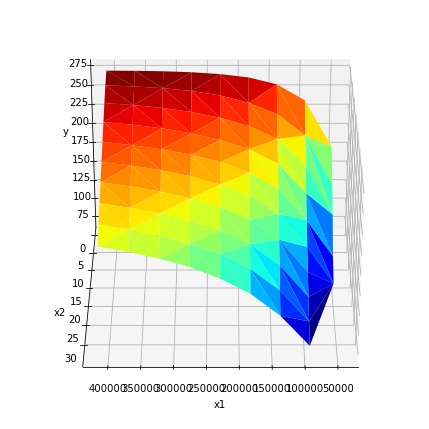

In [90]:
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.azim = 90 # The azimuth is the rotation around the z axis [ 0 means "looking from x2" 90 means "looking from x1"]
#ax.dist = 10 # the distance from the center visible point in data coordinates
#ax.elev = 10 # is the angle between the eye and the xy plane
surf = ax.plot_trisurf(x[0:,0], x[0:,1], y, cmap=cm.jet)


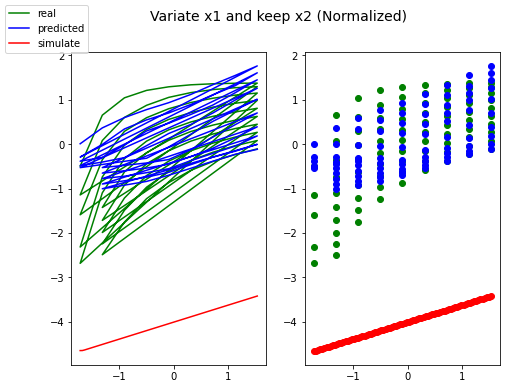

In [114]:
t_x1_norm = np.array(x_norm).copy()
t_x1_norm[0:,0] = np.linspace(min(x_norm[0:,0]), max(x_norm[0:,0]), 85)
t_x1_norm[0:,1] = np.mean(x[0:,1])
t_y1_norm = model.predict(t_x1_norm)
pred_y = model.predict(x_norm)

fig = plt.gcf()
fig.suptitle("Variate x1 and keep x2 (Normalized)", fontsize=14)
plt.rcParams['figure.figsize'] = [1.2*6.4, 1.2*4.8]

plt.subplot(1, 2, 1) 
plt.plot(x_norm[0:,0], y_norm, 'g-', label='real')
plt.plot(x_norm[0:,0], pred_y, 'b-', label='predicted')
plt.plot(t_x1_norm[0:,0], t_y1_norm, 'r-', label='simulate') # variate x1 and keep x2 = mean(x2)        
fig.legend(loc="upper left")

plt.subplot(1, 2, 2)
plt.scatter(x_norm[0:,0], y_norm, c='g')
plt.scatter(x_norm[0:,0], pred_y, c='b')
plt.scatter(t_x1_norm[0:,0], t_y1_norm, c='r') 

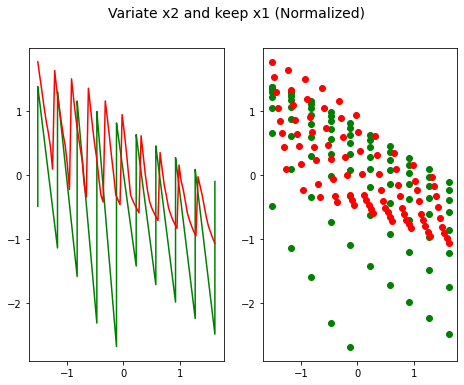

In [89]:
t_x2_norm = np.array(x_norm).copy()
t_x2_norm[0:,1] = np.linspace(min(x_norm[0:,1]), max(x_norm[0:,1]), 85)
t_y2_norm = model.predict(t_x2_norm)

fig = plt.gcf()
fig.suptitle("Variate x2 and keep x1 (Normalized)", fontsize=14)

plt.subplot(1, 2, 1)  
plt.plot(x_norm[0:,1],y_norm,'g-',
         t_x2_norm[0:,1],t_y2_norm,'r-')
plt.subplot(1, 2, 2)
plt.scatter(x_norm[0:,1],y_norm, c = 'g')
plt.scatter( t_x2_norm[0:,1],t_y2_norm, c = 'r') 

### Previous Implementations <a name="PreviousImplementations"></a>

In [63]:
def inicialize_bounds(weights):
    """
    Input
    weights : Weights of the neural network
    
    Output
    bounds : a zeros numpy array shapped as (total_neurons + len(input_dim), input_dim)
    """
    t = total_neurons(weights) + len(weights[0])
    bounds = np.zeros((t,2))
    return bounds


def bound_model(model, x, s, k, j, maximize):
    """
    Input
    model : model to optimize
    x, s  : variables of the model
    k, j  : layer and neuron, respectively
    maximize : objetive of the model (True == maximize False == minimize)
    
    Output
    new_bound : bound generated after the bound tightening procedure
    """
    if maximize:
        model.setObjective(x[k,j] - s[k,j], GRB.MAXIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    else:
        model.setObjective(x[k,j] - s[k,j], GRB.MINIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    return new_bound

In [64]:
def bound_tightening(parameters, weights):
    
    # Create the model
    m = Model('bound_tightening')
    m.Params.LogToConsole = 0 # turn off logs
    
    # Local Variables
    bounds = inicialize_bounds(weights)
    aux = 2 # index of the bounds array
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
    
    # Model Variables
    x = m.addVars(K, nK,lb=-5,ub=5) # decision variables
    s = m.addVars(K, nK, lb=0, ub=10) # negative dump
    z = m.addVars(K, nK, lb=0, ub=1) # binary activation variable
    y = m.addVar(lb=-5,ub=5) # output variable
       
    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x[0,0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x[0,0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x[0,1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x[0,1] <= (1 - mean_x[1])/std_x[1] )
    
    
    for i in range(len(W[0])): # iterates over the neural net inputs
        # Bounds of input
        m.setObjective(x[0,i], GRB.MAXIMIZE)
        m.optimize()
        ub = m.ObjVal
        m.setObjective(x[0,i], GRB.MINIMIZE)
        m.optimize()
        lb = m.ObjVal
        bounds[i,1], bounds[i,0] = lb, ub
    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]
                
                """ 
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1,i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x[k,j] - s[k,j] )
                
                
                bounds[aux,0] = bound_model(m, x, s, k, j, True)
                bounds[aux,1] = bound_model(m, x, s, k, j, False)
                
                # Classic ReLu Formulation
                m.addConstr( x[k,j] <= bounds[aux,0] * z[k,j] )
                m.addConstr( s[k,j] <= -bounds[aux,1] * (1 - z[k,j]) )
                m.addConstr( x[k,j] >= 0)
                               
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1,i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
                
                # Bounds of output
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[aux,1], bounds[aux,0] = lb, ub
                print(lb,ub)
            
            aux += 1
    
    return bounds

In [65]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
bounds = bound_tightening(parameters, W)
bounds

-2.246551803949021 1.7364051413861032


array([[ 1.72772608, -1.72772608],
       [ 1.72772608, -1.72772608],
       [ 0.64205439, -0.27340875],
       [ 0.96719348, -0.73286807],
       [ 1.17378792, -0.48834118],
       [ 0.2331374 , -1.15255043],
       [ 1.15094301, -0.25402936],
       [ 1.03169151, -0.20633246],
       [ 0.80162674, -0.75380247],
       [ 0.50661042, -0.83868536],
       [ 1.05711069, -0.11309143],
       [ 1.04564983, -0.71581283],
       [-0.22943133, -1.18742514],
       [ 0.82950059, -0.24681179],
       [ 0.5584421 , -0.26065242],
       [ 0.89848343, -0.49654192],
       [ 0.96073047, -0.16462877],
       [ 1.21993548, -0.34380913],
       [ 1.12247633, -0.07704481],
       [ 0.27382051, -0.70819428],
       [ 0.75028852,  0.05015983],
       [ 0.72975842, -0.18671328],
       [ 0.60837369, -0.68422108],
       [ 1.00806358, -0.44320637],
       [ 1.5012147 , -0.13275513],
       [ 1.15488415, -0.18326089],
       [ 1.03560569, -0.67558208],
       [ 0.2016631 , -2.89911724],
       [ 1.20067041,

In [43]:
def main_model_with_bounds(parameters, weights, bounds):
    
    # Create the model
    m = Model('bt')
    m.Params.LogToConsole = 0 # turn off logs
    
    # Local Variables
    aux = 2 # index of the bounds array
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
    
    # Model Variables
    x = m.addVars(K, nK,lb=bounds[0,1],ub=bounds[0,0]) # decision variables
    s = m.addVars(K, nK, lb=0, ub=10) # negative dump
    z = m.addVars(K, nK, vtype=GRB.BINARY) # binary activation variable
    y = m.addVar(lb=bounds[-1,1],ub=bounds[-1,0]) # output variable

    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x[0,0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x[0,0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x[0,1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x[0,1] <= (1 - mean_x[1])/std_x[1] )

    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]
                
                """ 
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1,i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x[k,j] - s[k,j] )
                
                # Classic ReLu Formulation
                if bounds[aux,0] < 0:
                    z[k,j].lb , z[k,j].ub = 0, 0
                if bounds[aux,1] > 0:
                    z[k,j].lb , z[k,j].ub = 1, 1
                    
                m.addConstr( x[k,j] <= bounds[aux,0] * z[k,j] )
                m.addConstr( s[k,j] <= - bounds[aux,1] * (1 - z[k,j]) )
                m.addConstr( x[k,j] >= 0)
                               
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1,i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
            
            aux += 1
    
    m.setObjective(y, GRB.MAXIMIZE)
    m.update()
    m.setParam("OutputFlag", 1)
    m.setParam("MIPGap", 1e-4)
    m.setParam("NonConvex", 2);
    m.optimize()

    print('Output')
    print('Normalized {}    Real {}'.format(y.x, y.x * std_y + mean_y))
  
    print('Input')
    print('Xo Normalized {}    Real {}'.format(x[0,0].x, x[0,0].x * std_x[0] + mean_x[0]))
    print('X1 Normalized {}    Real {}'.format(x[0,1].x, x[0,1].x * std_x[1] + mean_x[1]))


    print('binarias')
    print(len(z))


In [44]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
b = bound_tightening(parameters, W)
main_model_with_bounds(parameters, W, b)


NameError: name 'bound_tightening' is not defined